In [1]:
import silq
silq.initialize('Antimony', mode='analysis')

import peakutils

%matplotlib notebook

Initializing imports
Initializing functions
Initializing data
Initializing jupyter
Initializing logging
Initialization complete


In [85]:
def line_value(y_val, point, slope):
    return point[0] + 1/slope * (y_val - point[1])

def get_peaks(traces, max_x_dist=0.025):
    x_vals = traces.set_arrays[1][0]
    y_vals = traces.set_arrays[0]
    
    dx = x_vals[1] - x_vals[0]
    min_dist = int(round(max_x_dist / dx))
    threshold_peak = np.max(traces[:]) / 4

    peaks = []
    for k, trace in enumerate(traces):
        y_val = y_vals[k]
        peaks_idx = np.sort(peakutils.indexes(trace, 
                                              thres=threshold_peak, 
                                              min_dist=min_dist))
        peaks.append((x_vals[peaks_idx], y_val))
    return peaks

def get_transition_point(traces, set_vals, max_x_dist=0.05, origin_offset=(0.008, 0), slope=-1.5,
                         plot=False):
    origin_point = np.array(set_vals) + np.array(origin_offset)

    # Get list of peaks for each y value ([x_peaks], y_val)
    peaks = get_peaks(traces, max_x_dist=max_x_dist)

    # Find closest peaks
    closest_peaks = []
    for x_vals, y_val in peaks:
        origin_value = line_value(y_val, origin_point, slope)
        closest_peak = x_vals[np.argmin(abs(x_vals - origin_value))]

        # Only append peak if it is close to origin line
        if abs(closest_peak - origin_value) < max_x_dist:
            closest_peaks.append((closest_peak, y_val))
    closest_peaks = np.array(closest_peaks)

    dx_peaks = closest_peaks[1:, 0] - closest_peaks[:-1, 0]
    dy_peaks = closest_peaks[1:, 1] - closest_peaks[:-1, 1]
    y_peaks_midway = (closest_peaks[1:, 1] + closest_peaks[:-1, 1]) / 2
    dxdy_peaks = dx_peaks / dy_peaks

    transition_idx = np.argmax(dxdy_peaks)
    transition_point = (closest_peaks[transition_idx][0], y_peaks_midway[transition_idx])
    
    if plot:
        plot = MatPlot(subplots=(2, 1))
        plot[0].add(traces)

        for x_vals, y_val in peaks:
            plot[0].plot(x_vals, [y_val]*len(x_vals), 'ob')

        origin_values = line_value(y_vals, origin_point, slope)
        plot[0].plot(origin_values, y_vals, '-r')

        origin_values = line_value(y_vals, set_vals, slope)
        plot[0].plot(origin_values, y_vals, '-b')
        for x_val, y_val in closest_peaks:
            plot[0].plot(x_val,y_val, 'or')

        y_peaks_midway = (closest_peaks[1:, 1] + closest_peaks[:-1, 1]) / 2
        plot[1].plot(y_peaks_midway, dxdy_peaks)
        plot[0].plot(*transition_point, 'og', ms=5)
        plot[1].plot(transition_point[1], dxdy_peaks[transition_idx], 'og', ms=10)
    
    return transition_point

# Technique 1: finding points closest by

Works in some cases but not in others

In [2]:
# Works here
data = load_data(r'2017-05-30\#017_DC_sweep_11-14-09')

In [39]:
# Does not work here
data = load_data(r'2017-05-30\#019_DC_sweep_11-15-18')

In [3]:
data = load_data(r'2017-05-30\#022_DC_sweep_11-46-21')

<IPython.core.display.Javascript object>


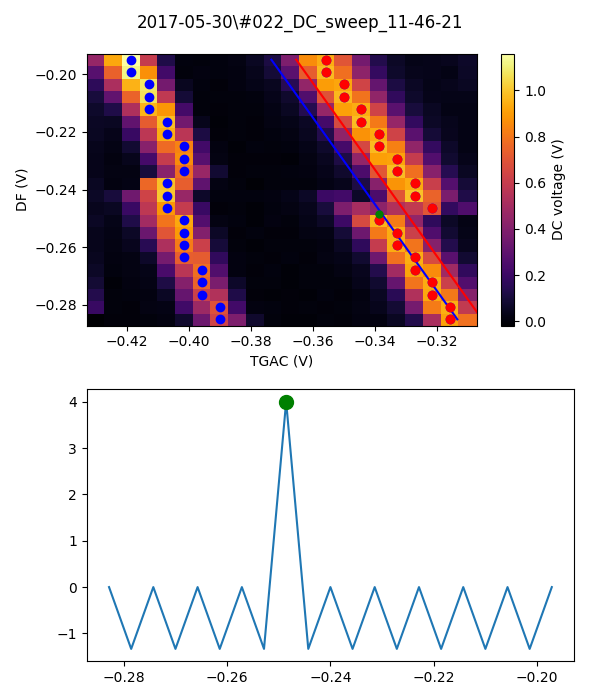

In [79]:
y_vals = data.DF_set.ndarray
traces = data.DC_voltage

max_x_dist = 0.05
slope = -1.5

set_vals = (-0.35, -0.23)
origin_offset = (0.008, 0)
origin_point = np.array(set_vals) + np.array(origin_offset)

# Get list of peaks for each y value ([x_peaks], y_val)
peaks = get_peaks(traces, max_x_dist=max_x_dist)

# Find closest peaks
closest_peaks = []
for x_vals, y_val in peaks:
    origin_value = line_value(y_val, origin_point, slope)
    closest_peak = x_vals[np.argmin(abs(x_vals - origin_value))]
    
    # Only append peak if it is close to origin line
    if abs(closest_peak - origin_value) < max_x_dist:
        closest_peaks.append((closest_peak, y_val))
closest_peaks = np.array(closest_peaks)

dx_peaks = closest_peaks[1:, 0] - closest_peaks[:-1, 0]
dy_peaks = closest_peaks[1:, 1] - closest_peaks[:-1, 1]
y_peaks_midway = (closest_peaks[1:, 1] + closest_peaks[:-1, 1]) / 2
dxdy_peaks = dx_peaks / dy_peaks

transition_idx = np.argmax(dxdy_peaks)
transition_point = (closest_peaks[transition_idx][0], y_peaks_midway[transition_idx])



# Technique 2: Segmenting peaks

In [23]:
data = load_data(r'2017-05-30\#019_DC_sweep_11-15-18')

In [24]:
y_vals = data.DF_set
traces = data.DC_voltage

peaks = get_peaks(traces)

slope = -1.5
origin_point = (-0.355, -0.23)
origin_values = origin_point[0] + 1/slope * (y_vals.ndarray - origin_point[1])